<a href="https://colab.research.google.com/github/pei0217/fin_hw2/blob/main/fin_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas scikit-learn matplotlib

[*********************100%***********************]  1 of 1 completed


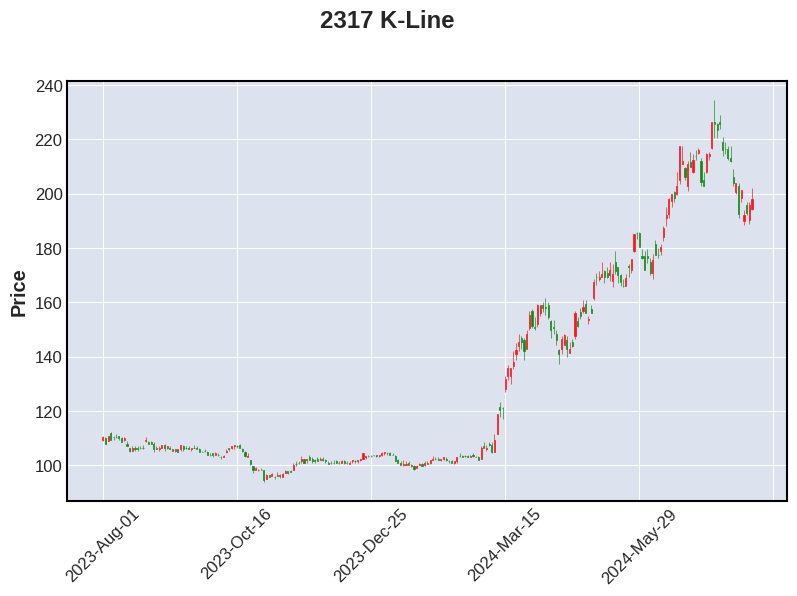

線性回歸 RMSE: 21.047265321677408
線性回歸模型預測未來1天的價格: 162.16


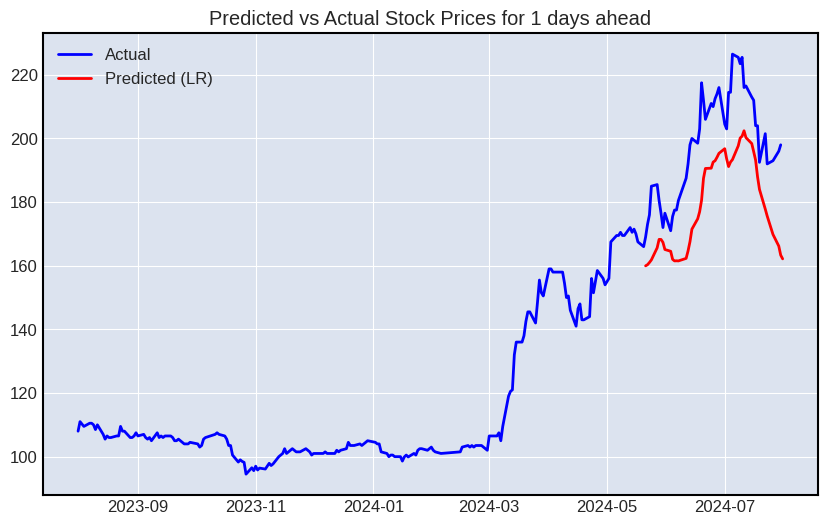

決策樹 RMSE: 46.43234455059159
決策樹模型預測未來1天的價格: 109.50


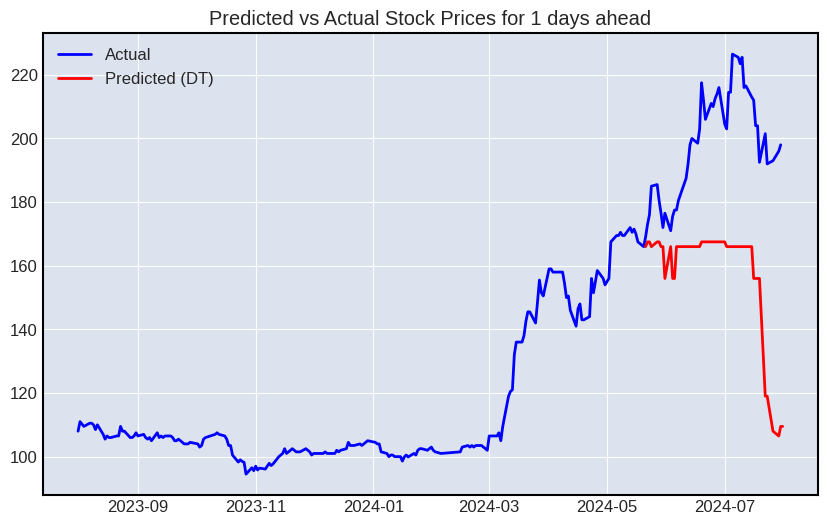

隨機森林 RMSE: 45.1966409161156
隨機森林模型預測未來1天的價格: 106.67


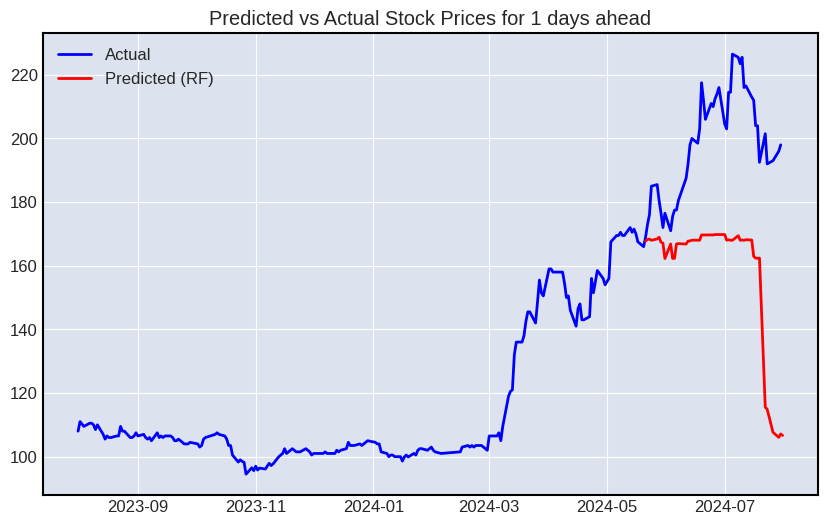

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import mplfinance as mpf

# 下載股票數據（以 AAPL 為例）
data = yf.download('2317.tw', start='2023-8-01', end='2024-8-01')

# 計算技術指標（SMA、RSI、MACD）
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI'] = calculate_rsi(data)

data['SMA_20'] = data['SMA_20'].fillna(data['SMA_20'].mean())  # 使用均值填補
data['RSI'] = data['RSI'].fillna(data['RSI'].mean())            # 使用均值填補
data['MACD'] = data['MACD'].fillna(data['MACD'].mean())          # 使用均值填補

# 設置預測的目標日期 n
n = 1
data[f'Close_{n}d'] = data['Close'].shift(-n)  # 標籤是 n 天後的股價

# 選擇特徵和目標
X = data[['SMA_20', 'RSI', 'MACD']]  # 特徵為技術指標
y = data[f'Close_{n}d']  # 標籤是 n 天後的股價

# 切分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# 使用均值填補 NaN
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())



# 構建回歸模型（線性回歸、決策樹、隨機森林）
# 線性回歸
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# 決策樹
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
# 隨機森林
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',marketcolors=my_color)
mpf.plot(data, type='candle', style=my_style, title='2317 K-Line', figsize=(10, 6))


# 顯示結果
future_pred_lr = lr.predict(X[-1:])
future_pred_dt = dt.predict(X[-1:])
future_pred_rf = rf.predict(X[-1:])

print(f"線性回歸 RMSE: {rmse_lr}")
print(f"線性回歸模型預測未來{n}天的價格: {future_pred_lr[0]:.2f}")
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_lr, label='Predicted (LR)', color='red')
plt.title(f'Predicted vs Actual Stock Prices for {n} days ahead')
plt.legend()
plt.show()

print(f"決策樹 RMSE: {rmse_dt}")
print(f"決策樹模型預測未來{n}天的價格: {future_pred_dt[0]:.2f}")
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_dt, label='Predicted (DT)', color='red')
plt.title(f'Predicted vs Actual Stock Prices for {n} days ahead')
plt.legend()
plt.show()

print(f"隨機森林 RMSE: {rmse_rf}")
print(f"隨機森林模型預測未來{n}天的價格: {future_pred_rf[0]:.2f}")
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y_test.index, y_pred_rf, label='Predicted (RF)', color='red')
plt.title(f'Predicted vs Actual Stock Prices for {n} days ahead')
plt.legend()
plt.show()
